### Load packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import numpy as np
import gseapy as gp

import seaborn as sns
import matplotlib.pyplot as plt

import dill


from post_analysis import *

from matplotlib_venn import venn2
from pathlib import Path

OBJ_DIR = Path("/home/jyj/PROJECT/2025/submission/covid_obj")
RNA_PATH = Path("/data3/projects/2025_GTRA/data/3_COVID/scRNA")

### Load dataset

In [2]:
# Clinical data
clinical = pd.read_csv("clinical.csv", index_col=0)

pid_pname = dict(clinical[['pid','pname']].values)
pname_pid = {val:key for key, val in pid_pname.items()}

### Detect patterns

In [5]:
all_patterns = pd.DataFrame()
for idx, pid in enumerate(pid_pname.keys()):
    
    pid_cl = clinical[clinical['pid'] == pid]
    
    paper_pname = pid_pname[pid]
    obj_fname = OBJ_DIR / f"{paper_pname}_covid.dill"
    
    if paper_pname == 'P2': continue
    with open(obj_fname, "rb") as f:
        obj = dill.load(f)
    
    pt_df, result_df, pt_dist = intra_pattern_clustering(obj)
    unique_ID = [f'{pid}_{i}' for i in result_df['Pattern_ID'].values]
    result_df['Unique_ID'] = unique_ID

    if idx == 0:
        all_patterns = result_df
    else:
        all_patterns = pd.concat([all_patterns,result_df])

filtered_df = all_patterns[all_patterns['trajectory'].str.contains('CD4|CD8|NK')].copy()

In [6]:
phenos, pid_ = [], []
for i in filtered_df['Unique_ID']:
    pid = i.split('_')[0]
    pheno = ''
    if pid_pname[pid] in ['P1','P2','P3','P4']:
        pheno = 'DP'
    else:
        pheno = 'RP'
    phenos.append(pheno)
    pid_.append(pid)

filtered_df['PID'] = pid_
filtered_df['Pheno'] = phenos

In [7]:
dp_df = filtered_df[filtered_df['Pheno'] == 'DP']
rp_df = filtered_df[filtered_df['Pheno'] == 'RP']

In [8]:
dp_df['Trend'].value_counts(),rp_df['Trend'].value_counts()

(Trend
 transient     12
 increasing     4
 Name: count, dtype: int64,
 Trend
 transient     19
 increasing     7
 decreasing     7
 Name: count, dtype: int64)

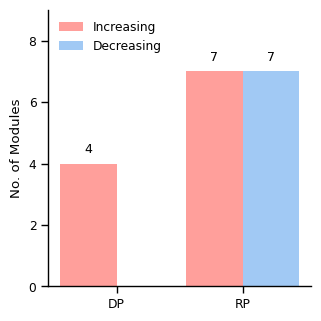

In [9]:
dp = pd.Series({'Transient': 12, 'Increasing': 4})
rp = pd.Series({'Transient': 19, 'Increasing': 7, 'Decreasing': 7})

# Increasing / Decreasing만 추출
order = ['Increasing', 'Decreasing']
dp = dp.reindex(order, fill_value=0)
rp = rp.reindex(order, fill_value=0)

# DataFrame (행: Group, 열: Trend)
df = pd.DataFrame({'Increasing': [dp['Increasing'], rp['Increasing']],
                   'Decreasing': [dp['Decreasing'], rp['Decreasing']]},
                  index=['DP', 'RP'])

# 스타일
sns.set_context("paper", font_scale=1.0)
plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# 색상 (Increasing=레드, Decreasing=블루)
inc_color = sns.color_palette("pastel")[3]
dec_color = sns.color_palette("pastel")[0]

# 플롯
fig, ax = plt.subplots(figsize=(3.3, 3.3))
x = np.arange(len(df.index))
w = 0.45

ax.bar(x - w/2, df['Increasing'], width=w, color=inc_color, label='Increasing')
ax.bar(x + w/2, df['Decreasing'], width=w, color=dec_color, label='Decreasing')

# 축 / 라벨
ax.set_xticks(x)
ax.set_xticklabels(df.index)  # DP, RP
ax.set_ylabel('No. of Modules')

# y축: 정수 눈금
ymax = int(df.values.max())
ax.set_ylim(0, ymax + 2)
ax.set_yticks(range(0, ymax + 2, 2))

# 수치 라벨
for i, (inc, dec) in enumerate(zip(df['Increasing'], df['Decreasing'])):
    if inc > 0:
        ax.text(i - w/2, inc + 0.25, f"{int(inc)}", ha='center', va='bottom', fontsize=9)
    if dec > 0:
        ax.text(i + w/2, dec + 0.25, f"{int(dec)}", ha='center', va='bottom', fontsize=9)

ax.legend(frameon=False, loc='upper left')

plt.tight_layout()
# plt.savefig('Trend_barplot.svg', bbox_inches='tight')
# plt.savefig('Trend_barplot.pdf', bbox_inches='tight')
plt.show()


In [10]:
decreaseing_key = rp_df[rp_df['Trend'] == 'decreasing']['Unique_ID'].values
increasing_key = dp_df[dp_df["Trend"] == "increasing"]["Unique_ID"].values

# For RP
decrease_set = []
for key in decreaseing_key:
    gs = filtered_df[filtered_df['Unique_ID']==key]['Genes'].values[0].split(';')
    decrease_set.extend(gs)

decrease_set = set(decrease_set)

# For DP
increase_set = []
for key in increasing_key:
    gs = filtered_df[filtered_df['Unique_ID']==key]['Genes'].values[0].split(';')
    increase_set.extend(gs)

increase_set = set(increase_set)

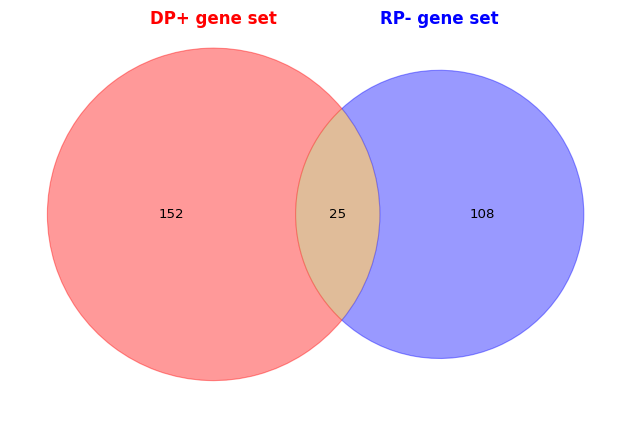

In [12]:
fig, ax = plt.subplots()
c = venn2([increase_set, decrease_set], set_labels=('', ''))  # 기본 라벨 비움

# 색상 설정
c.get_patch_by_id('10').set_color('red')
c.get_patch_by_id('01').set_color('blue')

# 원 중심 좌표 가져오기
left_center = c.get_circle_center(0)
right_center = c.get_circle_center(1)

# 라벨 텍스트 위쪽에 배치 (x, y 속성 사용)
ax.text(left_center.x, left_center.y + 0.5, 'DP+ gene set',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='red')
ax.text(right_center.x, right_center.y + 0.5, 'RP- gene set',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='blue')

plt.tight_layout()
plt.savefig("Inter_venn.pdf")
plt.show()


### Enrichment analysis

In [13]:
names = gp.get_library_name(organism="Human")

# GO Biological Process enrichment
enr_inc = gp.enrichr(gene_list=list(increase_set),
                     gene_sets=['MSigDB_Hallmark_2020'],
                     organism='Human',
                     cutoff=0.05)

enr_dec = gp.enrichr(gene_list=list(decrease_set),
                     gene_sets=['MSigDB_Hallmark_2020'],
                     organism='Human',
                     cutoff=0.05)


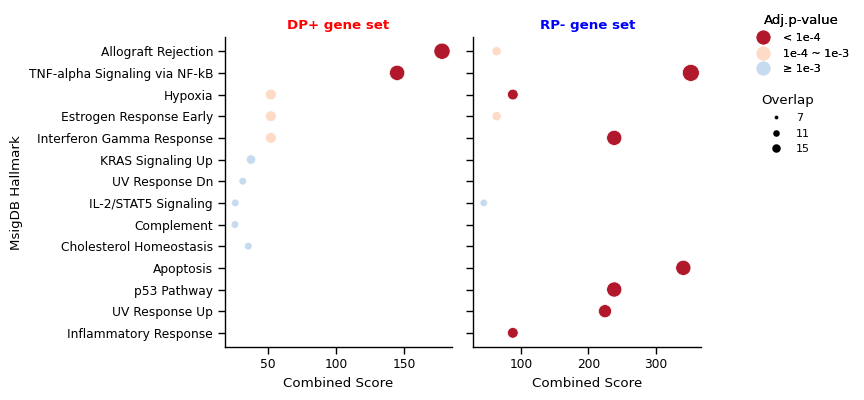

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import numpy as np
import re
from matplotlib.lines import Line2D

# --- 공통 준비 ---
def overlap_n(x):
    m = re.match(r"\s*(\d+)\s*/", str(x))
    return int(m.group(1)) if m else np.nan

def categorize_pval(p):
    if p < 1e-4:
        return "< 1e-4"
    elif p < 1e-3:
        return "1e-4 ~ 1e-3"
    else:
        return "≥ 1e-3"

top_inc = enr_inc.res2d.head(10)
top_dec = enr_dec.res2d.head(10)

top_inc = top_inc.copy()
top_dec = top_dec.copy()
for df in (top_inc, top_dec):
    df["Overlap_n"] = df["Overlap"].apply(overlap_n)
    df["pval_cat"]  = df["Adjusted P-value"].astype(float).apply(categorize_pval)

# p-value
pval_order = ["< 1e-4", "1e-4 ~ 1e-3", "≥ 1e-3"]
palette = {"< 1e-4": "#b2182b", "1e-4 ~ 1e-3": "#fddbc7", "≥ 1e-3": "#c6dbef"}

size_min, size_max = 30, 150
size_norm = mpl.colors.Normalize(vmin=7, vmax=15)  # 7~15 범위에 고정
size_ticks = [7, 11, 15]

fig, axs = plt.subplots(1, 2, figsize=(7.2, 4), sharey=True)

# Increasing
sns.scatterplot(
    data=top_inc, x='Combined Score', y='Term',
    size='Overlap_n', sizes=(size_min, size_max), size_norm=size_norm,
    hue='pval_cat', hue_order=pval_order, palette=palette, ax=axs[0]
)
axs[0].set_title('DP+ gene set', fontweight='bold', color='red')
axs[0].set_ylabel('MsigDB Hallmark')
axs[0].invert_yaxis()
axs[0].spines['top'].set_visible(False); axs[0].spines['right'].set_visible(False)
axs[0].get_legend().remove()

# Decreasing
sns.scatterplot(
    data=top_dec, x='Combined Score', y='Term',
    size='Overlap_n', sizes=(size_min, size_max), size_norm=size_norm,
    hue='pval_cat', hue_order=pval_order, palette=palette, ax=axs[1]
)
axs[1].set_title('RP- gene set', fontweight='bold', color='blue')
axs[1].spines['top'].set_visible(False); axs[1].spines['right'].set_visible(False)
axs[1].get_legend().remove()

# --- 공통 범례(수동) ---
# (1) p-value 색상 범례
color_handles = [Line2D([0], [0], marker='o', linestyle='',
                        markerfacecolor=palette[k], markeredgecolor='none',
                        markersize=10, label=k) for k in pval_order]
leg1 = fig.legend(color_handles, pval_order, title="Adj.p-value",
                  loc='upper right', bbox_to_anchor=(1.2, 1.00),
                  frameon=False, fontsize=8)

def size_for(v):
    return np.interp(v, [7, 15], [size_min, size_max])

size_handles = [Line2D([0], [0], marker='o', linestyle='',
                       markerfacecolor="black", markeredgecolor='none',
                       markersize=np.sqrt(size_for(v))/2.0, label=str(v))
                for v in size_ticks]
leg2 = fig.legend(size_handles, [str(v) for v in size_ticks], title="Overlap",
                  loc='upper right', bbox_to_anchor=(1.15, 0.8),
                  frameon=False, fontsize=8)

axs[1].add_artist(leg1)

plt.tight_layout()
plt.savefig('MsigDB_dotplot_shared.pdf', dpi=300, bbox_inches='tight')
plt.show()


### Shared genes

In [16]:
inter_genes = list(set(increase_set).intersection(set(decrease_set)))

scrna = sc.read_h5ad(RNA_PATH / 'scRNA_preproc.h5ad')

tnk = scrna[(scrna.obs["mye_sub"]=="CD4+T")|
          (scrna.obs["mye_sub"]=="CD8+T")|
          (scrna.obs["mye_sub"]=="NK")]

In [17]:
pheno_dict = {'P1':"DP", 'P2':"DP", 'P3':"DP", 'P4':"DP", 
              'P5':"RP", 'P6':"RP",'P7':"RP",'P8':"RP"}

tnk.obs["Pheno"] = tnk.obs["Pname"].map(pheno_dict)

/tmp/ipykernel_3351966/2632154110.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tnk.obs["Pheno"] = tnk.obs["Pname"].map(pheno_dict)


In [18]:
rp_tnk = tnk[tnk.obs["Pheno"]=="RP"]
dp_tnk = tnk[tnk.obs["Pheno"]=="DP"]

In [19]:
sc.tl.pca(tnk, n_comps=30),
sc.tl.umap(tnk)

/data1/home/jyj/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


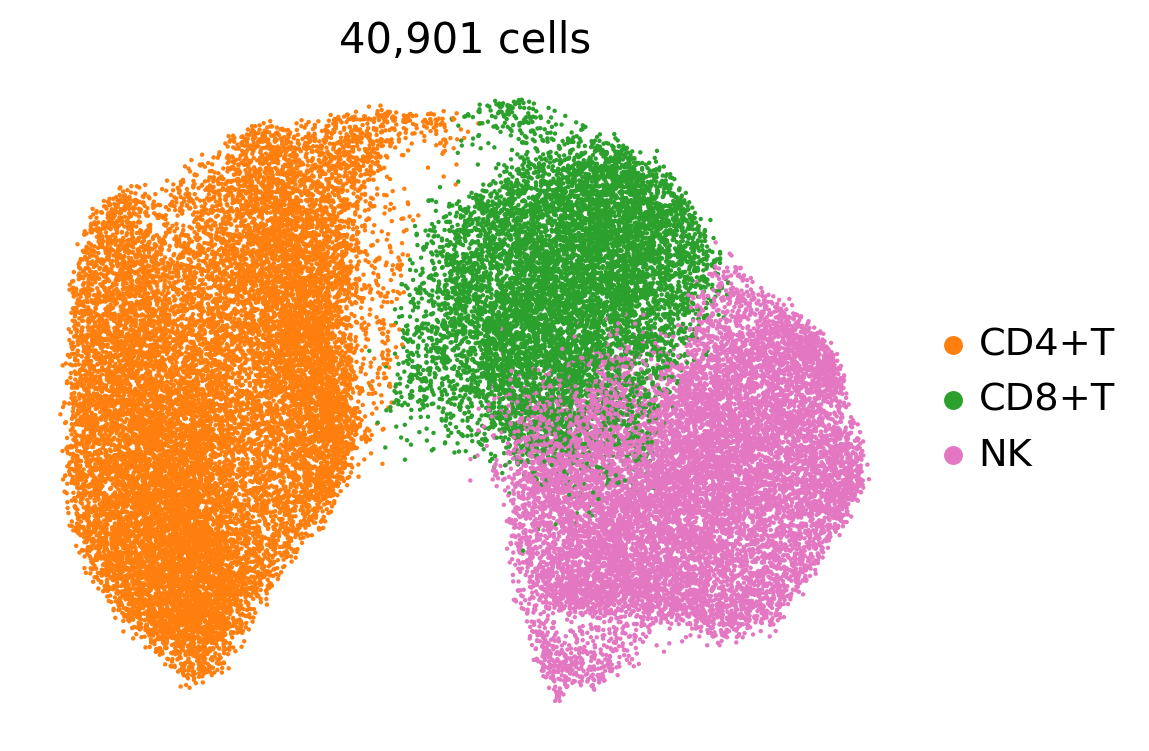

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
sc.set_figure_params(fontsize=15, figsize=(7,4))
sc.pl.umap(tnk, color=["mye_sub"],s=10, frameon=False, title="40,901 cells", ax=axs, show=False)
for ax in fig.axes:
    for coll in ax.collections:
        coll.set_rasterized(True)

plt.tight_layout()
plt.savefig("NKT_sc.pdf")

In [21]:
sc.tl.score_genes(tnk, gene_list = inter_genes, score_name="InterGenes")

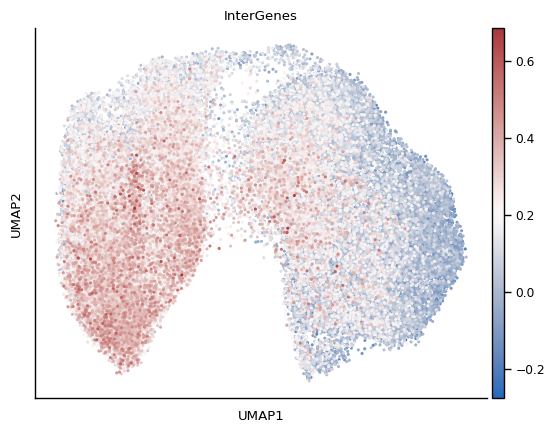

In [43]:
sc.pl.umap(tnk, color=["InterGenes"], cmap='vlag', size=20)

### Recovering Patient [P6]

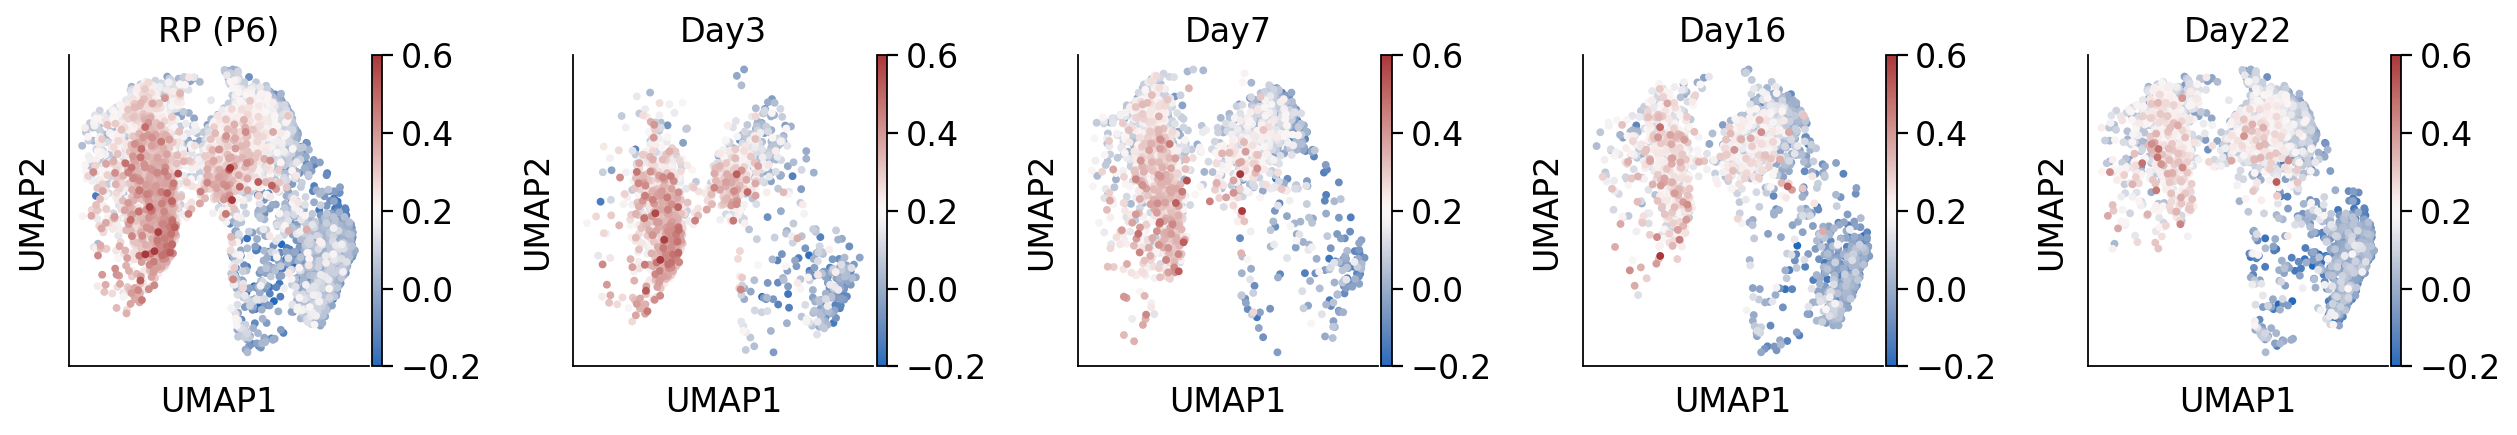

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,3))
P6_tnk = tnk[tnk.obs["Pname"]=="P6"]
sc.pl.umap(P6_tnk, color=["InterGenes"],cmap="vlag", vmin=-0.2,vmax=0.6,s=50, 
           ax=axs[0],show=False, frameon=True, title="RP (P6)")
sc.pl.umap(P6_tnk[P6_tnk.obs["Dates"]=="Day3"], color=["InterGenes"],cmap="vlag", 
           vmin=-0.2,vmax=0.6,s=50, ax=axs[1],show=False, frameon=True, title="Day3")
sc.pl.umap(P6_tnk[P6_tnk.obs["Dates"]=="Day7"], color=["InterGenes"],cmap="vlag", 
           vmin=-0.2,vmax=0.6,s=50, ax=axs[2],show=False, frameon=True, title="Day7")
sc.pl.umap(P6_tnk[P6_tnk.obs["Dates"]=="Day16"], color=["InterGenes"],cmap="vlag", 
           vmin=-0.2,vmax=0.6,s=50, ax=axs[3],show=False, frameon=True, title="Day16")
sc.pl.umap(P6_tnk[P6_tnk.obs["Dates"]=="Day22"], color=["InterGenes"],cmap="vlag", 
           vmin=-0.2,vmax=0.6,s=50, ax=axs[4],show=False, frameon=True, title="Day22")

for ax in fig.axes:
    for coll in ax.collections:
        coll.set_rasterized(True)

plt.tight_layout()
plt.savefig("P6(RP)_sg.pdf")

### Deteriorating Patient [P1]

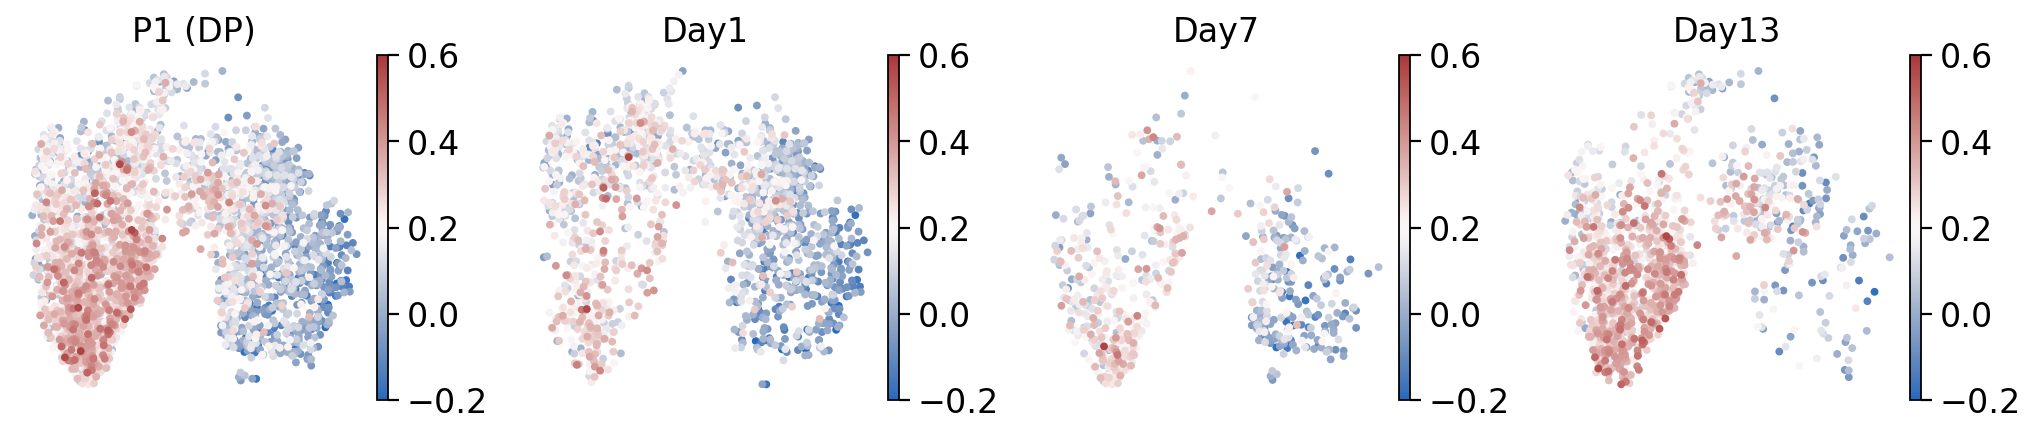

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13,3))
P1_tnk = tnk[tnk.obs["Pname"]=="P1"]
sc.pl.umap(P1_tnk, color=["InterGenes"],cmap="vlag", vmin=-0.2,vmax=0.6,
           s=50, ax=axs[0],show=False, frameon=False, title="P1 (DP)")
sc.pl.umap(P1_tnk[P1_tnk.obs["Dates"]=="Day1"], color=["InterGenes"],cmap="vlag", 
           vmin=-0.2,vmax=0.6,s=50, ax=axs[1],show=False, frameon=False, title="Day1")
sc.pl.umap(P1_tnk[P1_tnk.obs["Dates"]=="Day7"], color=["InterGenes"],cmap="vlag", 
           vmin=-0.2,vmax=0.6,s=50, ax=axs[2],show=False, frameon=False, title="Day7")
sc.pl.umap(P1_tnk[P1_tnk.obs["Dates"]=="Day13"], color=["InterGenes"],cmap="vlag", 
           vmin=-0.2,vmax=0.6,s=50, ax=axs[3],show=False, frameon=False, title="Day13")

for ax in fig.axes:
    for coll in ax.collections:
        coll.set_rasterized(True)

plt.tight_layout()
plt.savefig("P1(DP)_sg.pdf")